In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import spearmanr
import networkx as nx

from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import MDS, Isomap, LocallyLinearEmbedding, TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import pairwise_distances
from sklearn.datasets import make_s_curve
from sklearn.metrics import accuracy_score

import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
from torch_geometric.nn import Node2Vec

torch.manual_seed(42)
np.random.seed(42)

/opt/anaconda3/lib/python3.11/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/opt/anaconda3/lib/python3.11/site-packages/libpyg.so, 0x0006): tried: '/opt/anaconda3/lib/python3.11/site-packages/libpyg.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/opt/anaconda3/lib/python3.11/site-packages/libpyg.so' (no such file), '/opt/anaconda3/lib/python3.11/site-packages/libpyg.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64'))
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/opt/anaconda3/lib/python3.11/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/opt/anaconda3/lib/python3.11/site-packages/libpyg.so, 0x0006): tried: '/opt/anaconda3/lib/python3.11/site-packages/libpyg.so' (mac

# Problem 1

In [2]:
M = np.array([
    [5, 4, 2, 0, 0, 0],
    [0, 0, 0, 4, 2, 0],
    [5, 3, 3, 0, 0, 0],
    [0, 0, 0, 3, 5, 4],
    [5, 3, 5, 0, 0, 2],
    [0, 0, 2, 4, 5, 3],
    [4, 5, 4, 0, 0, 0]
], dtype=float)
users  = ["Anna","Blake","Chris","Diana","Emil","Felix","Gabriella"]
movies = ["Matrix","Star Wars","Jurassic Park","Titanic","La La Land","Amelie"]

# M = U Σ V^T
U, Sigma, Vt = np.linalg.svd(M, full_matrices=False)
print("Singular values:", Sigma)
print()
print("Matrix U: \n", U)
print()
print("Matrix Vt: \n", Vt)


Singular values: [14.16414875 10.57294154  3.24818406  2.30083032  1.79585698  0.7212317 ]

Matrix U: 
 [[-0.45180267 -0.11645102 -0.27665261  0.56378533  0.11082204 -0.06143119]
 [-0.03190929  0.34079287 -0.76439358 -0.26433877  0.25077774 -0.38051855]
 [-0.45165913 -0.10188021 -0.11106999  0.0934692   0.41865597  0.57454464]
 [-0.08283946  0.6423073   0.27647846  0.55910635 -0.04868806 -0.26132517]
 [-0.5435124  -0.0164489   0.47005644 -0.41561574  0.33371652 -0.43785004]
 [-0.15158027  0.659601    0.04386378 -0.32357408 -0.12060129  0.50621494]
 [-0.51537898 -0.10962254 -0.16586687 -0.11618128 -0.78820953 -0.07122664]]

Matrix Vt: 
 [[-0.6563322  -0.52030096 -0.51826773 -0.06936362 -0.08725672 -0.13224398]
 [-0.15250163 -0.1294724   0.02458395  0.56072355  0.68014442  0.42704619]
 [-0.0775197  -0.26445097  0.27339187 -0.63194812  0.02245072  0.67041093]
 [ 0.32313067  0.30762604 -0.77449158 -0.29308218  0.28206503  0.18883255]
 [ 0.6476766  -0.69083564 -0.13800994  0.20861439 -0.192

In [3]:
def predicting(k):
    # k is the number of singular values retained
    Vt_k   = Vt[:k, :]
    print("\nMovie factors in %dD space:" % k)
    for i, mov in enumerate(movies):
        print(f"{mov}: {Vt_k.T[i]}")
    
    henry = np.array([0, 5, 0, 0, 0, 0], dtype=float)
    henry_coords = henry @ Vt_k.T
    print("\nHenry's coordinates in the %dD movie space:" % k, henry_coords)

    # making recommendations based on distance
    dists = []
    for i, mov in enumerate(movies):
        dist = np.linalg.norm( henry_coords - Vt_k.T[i] )
        dists.append((mov, dist))

    # Sort movies by ascending distance
    dists.sort(key=lambda x: x[1])
    print("\nMovies ranked by proximity to Henry in %dD space:" % k)
    for movie_name, dist_val in dists:
        print(f"  {movie_name:15s} distance = {dist_val:.3f}")

In [4]:
print("\033[1;31m=== If we keep 2 singular values ===\033[0m")
predicting(2)

=== If we keep 2 singular values ===

Movie factors in 2D space:
Matrix: [-0.6563322  -0.15250163]
Star Wars: [-0.52030096 -0.1294724 ]
Jurassic Park: [-0.51826773  0.02458395]
Titanic: [-0.06936362  0.56072355]
La La Land: [-0.08725672  0.68014442]
Amelie: [-0.13224398  0.42704619]

Henry's coordinates in the 2D movie space: [-2.60150479 -0.64736201]

Movies ranked by proximity to Henry in 2D space:
  Matrix          distance = 2.007
  Star Wars       distance = 2.145
  Jurassic Park   distance = 2.189
  Amelie          distance = 2.693
  Titanic         distance = 2.806
  La La Land      distance = 2.843


In [5]:
print()
print("\033[1;31m===If we keep 3 singular values ===\033[0m")
predicting(3)


===If we keep 3 singular values ===

Movie factors in 3D space:
Matrix: [-0.6563322  -0.15250163 -0.0775197 ]
Star Wars: [-0.52030096 -0.1294724  -0.26445097]
Jurassic Park: [-0.51826773  0.02458395  0.27339187]
Titanic: [-0.06936362  0.56072355 -0.63194812]
La La Land: [-0.08725672  0.68014442  0.02245072]
Amelie: [-0.13224398  0.42704619  0.67041093]

Henry's coordinates in the 3D movie space: [-2.60150479 -0.64736201 -1.32225483]

Movies ranked by proximity to Henry in 3D space:
  Matrix          distance = 2.362
  Star Wars       distance = 2.391
  Jurassic Park   distance = 2.709
  Titanic         distance = 2.889
  La La Land      distance = 3.145
  Amelie          distance = 3.350


# Problem 4

In [6]:
N=1000
# S-Curve data
np.random.seed(0)
S, color_s = make_s_curve(n_samples=N, noise=0.0, random_state=0)

# Cylinder data
# Parameterize with angle theta in [0, 2*pi], z in [-1, 1].
theta = 2 * np.pi * np.random.rand(N)
z = 2.0 * np.random.rand(N) - 1.0
X_cyl = np.vstack([np.cos(theta), np.sin(theta), z]).T
color_cyl = theta

print('Data Generation Completed')

Data Generation Completed


In [7]:

def plot_3d_point_cloud(X3D, color, title="3D Data"):
    """Utility to plot a 3D point cloud."""
    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X3D[:,0], X3D[:,1], X3D[:,2], c=color, cmap=plt.cm.viridis)
    ax.set_title(title)
    plt.show()

def run_manifold_methods(X3D, color, n_neighbors=10, n_components=2, random_state=0, dataset_name="Data"):
    """
    Applies MDS, Isomap, and LLE on the 3D data X3D and returns their 2D embeddings.
    Also creates a figure to visualize them.
    """
    # MDS
    mds = MDS(n_components=n_components, random_state=random_state)
    X_mds = mds.fit_transform(X3D)
    
    # Isomap
    iso = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    X_iso = iso.fit_transform(X3D)
    
    # LLE
    lle = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components,
                                 method='standard', random_state=random_state)
    X_lle = lle.fit_transform(X3D)
    
    # Plot 2D embeddings
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    for ax, emb, name in zip(axes, [X_mds, X_iso, X_lle], ["MDS", "Isomap", "LLE"]):
        sc = ax.scatter(emb[:,0], emb[:,1], c=color, cmap=plt.cm.viridis)
        ax.set_title(f"{dataset_name} - {name}")
    plt.tight_layout()
    plt.show()
    
    return X_mds, X_iso, X_lle

def compute_q_scores(X_original, X_embedded, method_name="Method"):
    """
    Compute:
      - Local Q-score: Average fraction of shared 5-nearest neighbors 
      - Global Q-score: Spearman correlation between pairwise distances in original and embedded spaces
    """
    

    # Compute pairwise distances in original and embedded spaces
    D_orig = pairwise_distances(X_original)
    D_emb = pairwise_distances(X_embedded)
    
    # Global Q-score: Compute Spearman correlation of the flattened distance matrices
    idx_triu = np.triu_indices_from(D_orig, k=1)
    dist_orig = D_orig[idx_triu]
    dist_emb = D_emb[idx_triu]
    corr, _ = spearmanr(dist_orig, dist_emb)
    
    # Local Q-score: Compute nearest neighbors in the original and embedded spaces
    n_neighbors = 5
    nbrs_orig = NearestNeighbors(n_neighbors=n_neighbors, metric="precomputed").fit(D_orig)
    nn_orig = nbrs_orig.kneighbors(return_distance=False)
    
    nbrs_emb = NearestNeighbors(n_neighbors=n_neighbors, metric="precomputed").fit(D_emb)
    nn_emb = nbrs_emb.kneighbors(return_distance=False)
    
    # Average the fraction of shared neighbors across all samples
    local_score = 0.0
    for i in range(X_original.shape[0]):
        shared_neighbors = np.intersect1d(nn_orig[i], nn_emb[i])
        local_score += len(shared_neighbors) / n_neighbors
    local_score /= X_original.shape[0]
    
    print(f"{method_name} | Local Q-score = {local_score:.3f}, Global Q-score = {corr:.3f}")

print('Helper Functions Defined')

Helper Functions Defined


=== S-Curve Data Plots ===


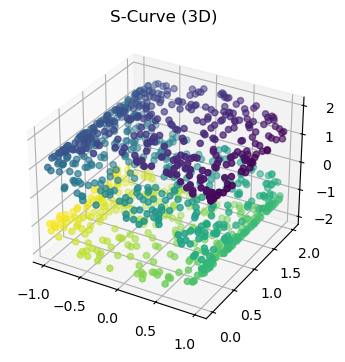

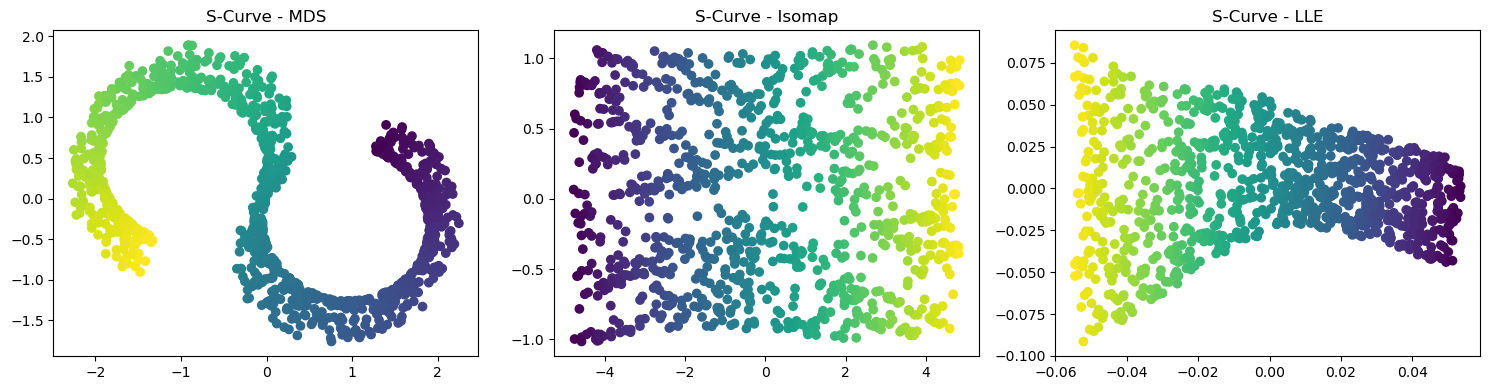

Q-Scores for S-Curve Embeddings:
MDS | Local Q-score = 0.462, Global Q-score = 0.964
Isomap | Local Q-score = 0.849, Global Q-score = 0.902
LLE | Local Q-score = 0.596, Global Q-score = 0.743


In [8]:
print("\033[1;31m=== S-Curve Data Plots ===\033[0m")
plot_3d_point_cloud(S, color_s, title="S-Curve (3D)")
S_mds, S_iso, S_lle = run_manifold_methods(S, color_s, n_neighbors=12, dataset_name="S-Curve")

print("\033[1;31mQ-Scores for S-Curve Embeddings:\033[0m")
compute_q_scores(S, S_mds, method_name="MDS")
compute_q_scores(S, S_iso, method_name="Isomap")
compute_q_scores(S, S_lle, method_name="LLE")


=== Cylinder Data Plots ===


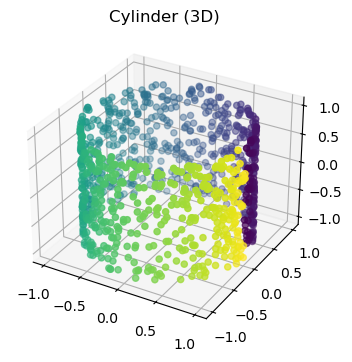

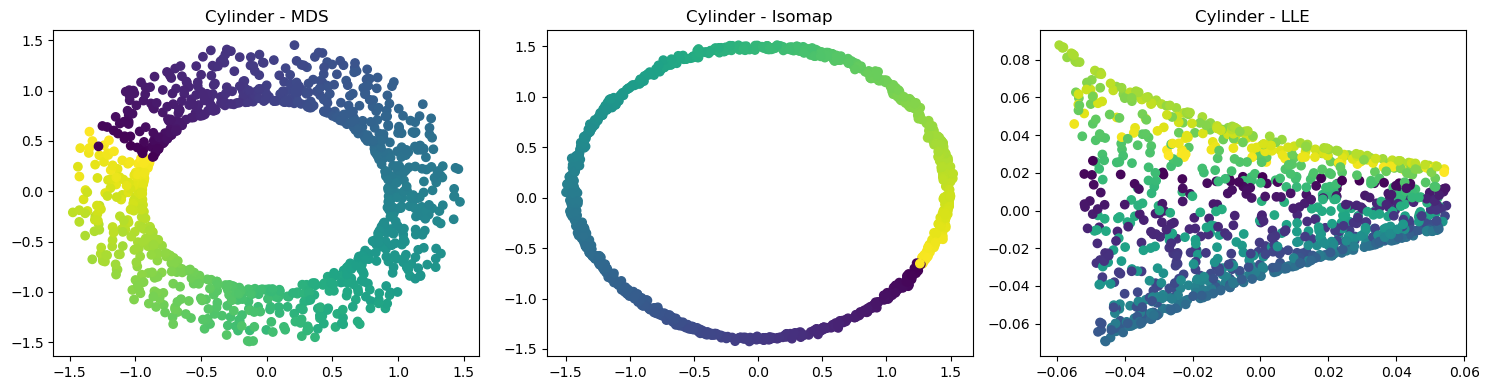

Q-Scores for Cylinder Embeddings:
MDS | Local Q-score = 0.497, Global Q-score = 0.889
Isomap | Local Q-score = 0.196, Global Q-score = 0.870
LLE | Local Q-score = 0.425, Global Q-score = 0.629


In [9]:
print("\n\033[1;31m=== Cylinder Data Plots ===\033[0m")
plot_3d_point_cloud(X_cyl, color_cyl, title="Cylinder (3D)")
C_mds, C_iso, C_lle = run_manifold_methods(X_cyl, color_cyl, n_neighbors=12, dataset_name="Cylinder")

print("\033[1;31mQ-Scores for Cylinder Embeddings:\033[0m")
compute_q_scores(X_cyl, C_mds, method_name="MDS")
compute_q_scores(X_cyl, C_iso, method_name="Isomap")
compute_q_scores(X_cyl, C_lle, method_name="LLE")

# Problem 5

In [10]:
# Obtaining Data
dataset_cora = Planetoid(root='data/Planetoid', name='Cora')
data_cora = dataset_cora[0]

dataset_citeseer = Planetoid(root='data/Planetoid', name='CiteSeer')
data_citeseer = dataset_citeseer[0]

print(f"Cora has {data_cora.num_nodes} nodes and {data_cora.num_edges} edges.")
print(f"CiteSeer has {data_citeseer.num_nodes} nodes and {data_citeseer.num_edges} edges.")


Cora has 2708 nodes and 10556 edges.
CiteSeer has 3327 nodes and 9104 edges.


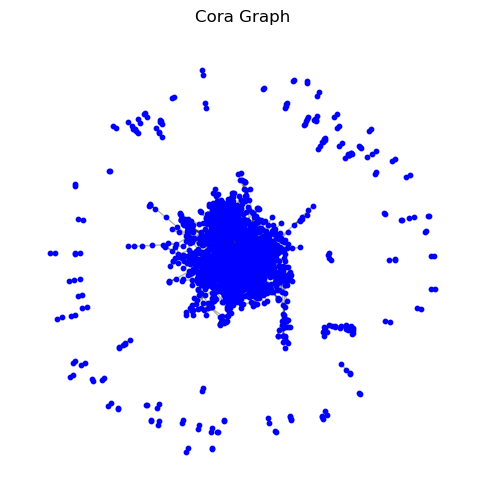

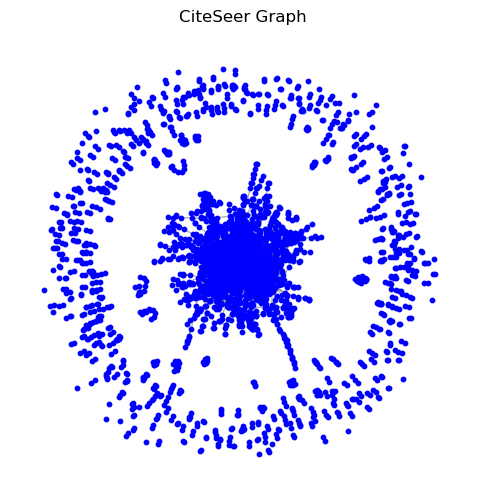

In [11]:
def plot_graph(data, title):
    # Convert to networkx for quick visualization
    G = to_networkx(data, to_undirected=True)
    plt.figure(figsize=(6, 6))
    pos = nx.spring_layout(G, seed=42)  # positions for all nodes
    nx.draw_networkx_nodes(G, pos, node_size=10, node_color='blue')
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title(title)
    plt.axis('off')
    plt.show()

plot_graph(data_cora, "Cora Graph")
plot_graph(data_citeseer, "CiteSeer Graph")

In [12]:

def train_node2vec(data, walk_length=20, context_size=10, walks_per_node=10,
                   p=1.0, q=1.0, embedding_dim=64, epochs=75, lr=0.01):
    """
    Trains a Node2Vec model (can emulate DeepWalk by p=1,q=1).
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    edge_index = data.edge_index.to(device)

    model = Node2Vec(
        edge_index, 
        embedding_dim=embedding_dim,
        walk_length=walk_length,
        context_size=context_size,
        walks_per_node=walks_per_node,
        p=p, 
        q=q,
        sparse=True
    ).to(device)

    loader = model.loader(batch_size=128, shuffle=True)
    optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=lr)

    model.train()
    for epoch in range(1, epochs+1):
        total_loss = 0
        for pos_rw, neg_rw in loader:
            optimizer.zero_grad()
            loss = model.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch: {epoch}, Loss: {total_loss:.4f}")
    
    # Return final embeddings
    return model.forward()

print("Model Training Defined")

Model Training Defined


In [13]:
print("=== Cora: Training DeepWalk (p=1,q=1) ===")
emb_cora_deepwalk = train_node2vec(data_cora, p=1.0, q=1.0)

print("\n=== Cora: Training Node2Vec BFS (p=0.25,q=4) ===")
emb_cora_n2v_bfs = train_node2vec(data_cora, p=0.25, q=4.0)

print("\n=== Cora: Training Node2Vec DFS (p=4,q=0.25) ===")
emb_cora_n2v_dfs = train_node2vec(data_cora, p=4, q=0.25)

print("\033[1;31mTraining for Cora is Complete!\033[0m")

=== Cora: Training DeepWalk (p=1,q=1) ===
Epoch: 1, Loss: 121.2291
Epoch: 2, Loss: 88.8062
Epoch: 3, Loss: 69.7151
Epoch: 4, Loss: 57.0917
Epoch: 5, Loss: 48.1427
Epoch: 6, Loss: 41.2271
Epoch: 7, Loss: 36.0505
Epoch: 8, Loss: 32.1934
Epoch: 9, Loss: 29.2499
Epoch: 10, Loss: 27.0503
Epoch: 11, Loss: 25.3066
Epoch: 12, Loss: 24.0399
Epoch: 13, Loss: 23.0443
Epoch: 14, Loss: 22.2640
Epoch: 15, Loss: 21.6246
Epoch: 16, Loss: 21.1725
Epoch: 17, Loss: 20.7856
Epoch: 18, Loss: 20.4662
Epoch: 19, Loss: 20.1882
Epoch: 20, Loss: 19.9551
Epoch: 21, Loss: 19.7851
Epoch: 22, Loss: 19.6119
Epoch: 23, Loss: 19.4763
Epoch: 24, Loss: 19.3787
Epoch: 25, Loss: 19.2736
Epoch: 26, Loss: 19.1733
Epoch: 27, Loss: 19.0935
Epoch: 28, Loss: 19.0210
Epoch: 29, Loss: 18.9369
Epoch: 30, Loss: 18.8907
Epoch: 31, Loss: 18.8670
Epoch: 32, Loss: 18.7927
Epoch: 33, Loss: 18.7803
Epoch: 34, Loss: 18.7188
Epoch: 35, Loss: 18.7042
Epoch: 36, Loss: 18.6921
Epoch: 37, Loss: 18.6381
Epoch: 38, Loss: 18.6055
Epoch: 39, Loss:

In [14]:
print("\n=== CiteSeer: Training DeepWalk (p=1,q=1) ===")
emb_citeseer_deepwalk = train_node2vec(data_citeseer, p=1.0, q=1.0)

print("\n=== CiteSeer: Training Node2Vec (p=0.25,q=4) ===")
emb_citeseer_n2v_bfs = train_node2vec(data_citeseer, p=0.25, q=4.0)

print("\n=== CiteSeer: Training Node2Vec (p=4,q=0.25) ===")
emb_citeseer_n2v_dfs = train_node2vec(data_citeseer, p=4.0, q=0.25)

print("\033[1;31mTraining for CiteSeer is Complete!\033[0m")


=== CiteSeer: Training DeepWalk (p=1,q=1) ===
Epoch: 1, Loss: 135.1000
Epoch: 2, Loss: 92.8838
Epoch: 3, Loss: 72.0834
Epoch: 4, Loss: 59.5884
Epoch: 5, Loss: 51.0121
Epoch: 6, Loss: 44.4597
Epoch: 7, Loss: 39.3876
Epoch: 8, Loss: 35.4997
Epoch: 9, Loss: 32.4790
Epoch: 10, Loss: 30.2744
Epoch: 11, Loss: 28.5118
Epoch: 12, Loss: 27.1499
Epoch: 13, Loss: 26.0767
Epoch: 14, Loss: 25.2445
Epoch: 15, Loss: 24.5536
Epoch: 16, Loss: 23.9858
Epoch: 17, Loss: 23.5231
Epoch: 18, Loss: 23.1507
Epoch: 19, Loss: 22.8053
Epoch: 20, Loss: 22.4897
Epoch: 21, Loss: 22.2778
Epoch: 22, Loss: 22.0521
Epoch: 23, Loss: 21.8590
Epoch: 24, Loss: 21.6892
Epoch: 25, Loss: 21.5346
Epoch: 26, Loss: 21.4169
Epoch: 27, Loss: 21.3091
Epoch: 28, Loss: 21.1832
Epoch: 29, Loss: 21.1010
Epoch: 30, Loss: 21.0099
Epoch: 31, Loss: 20.9491
Epoch: 32, Loss: 20.8361
Epoch: 33, Loss: 20.7579
Epoch: 34, Loss: 20.7178
Epoch: 35, Loss: 20.6654
Epoch: 36, Loss: 20.6211
Epoch: 37, Loss: 20.5688
Epoch: 38, Loss: 20.5175
Epoch: 39, 

In [15]:
def plot_embeddings(emb, labels, title):
    """
    emb: [num_nodes, embedding_dim] (torch.Tensor)
    labels: [num_nodes] (torch.Tensor)
    """
    emb = emb.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    tsne = TSNE(n_components=2, init='pca', random_state=42)
    emb_2d = tsne.fit_transform(emb)

    plt.figure(figsize=(6,5))
    plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels, cmap='Set2', s=10)
    plt.title(title)
    plt.colorbar()
    plt.show()


Plots for the Cora Embeddings


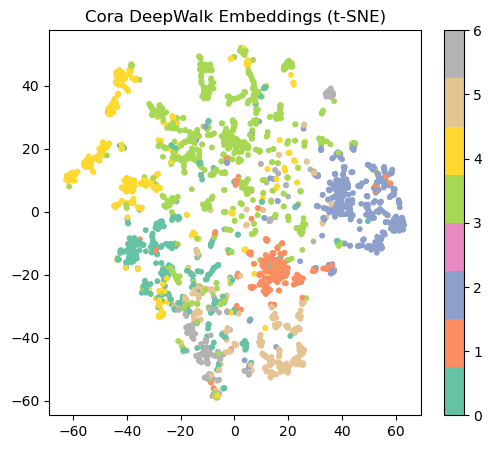

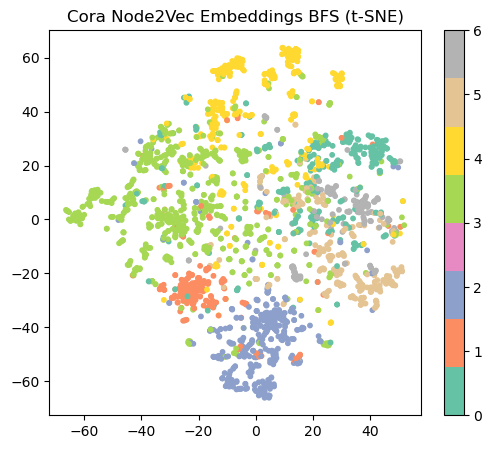

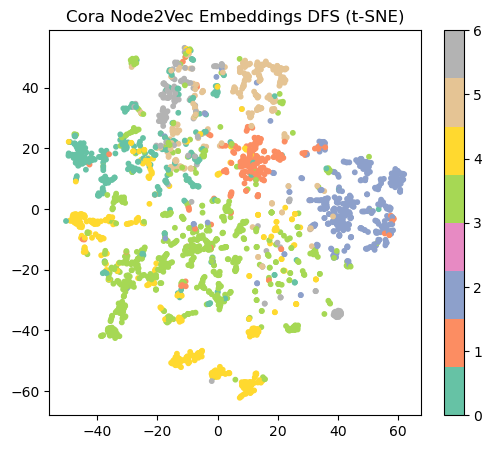

In [16]:
print("\033[1;31mPlots for the Cora Embeddings\033[0m")
plot_embeddings(emb_cora_deepwalk, data_cora.y, "Cora DeepWalk Embeddings (t-SNE)")
plot_embeddings(emb_cora_n2v_bfs, data_cora.y, "Cora Node2Vec Embeddings BFS (t-SNE)")
plot_embeddings(emb_cora_n2v_dfs, data_cora.y, "Cora Node2Vec Embeddings DFS (t-SNE)")

Plots for the CiteSeer Embeddings


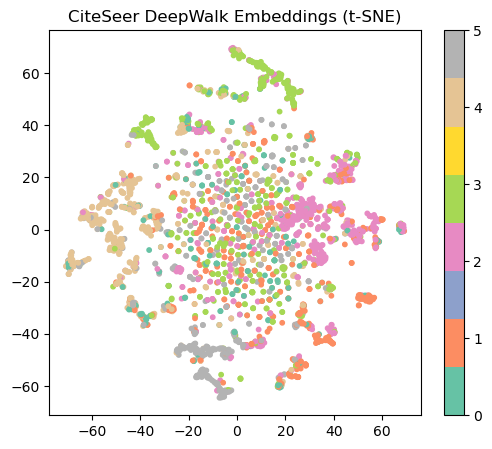

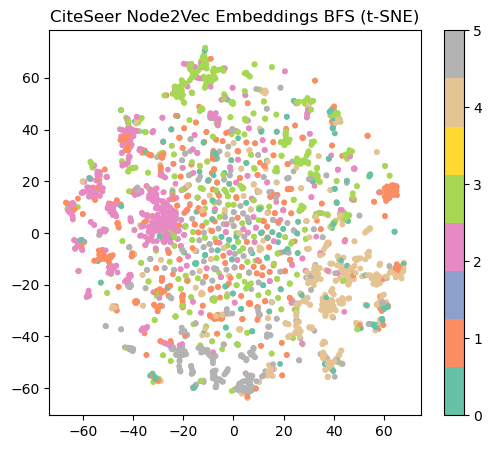

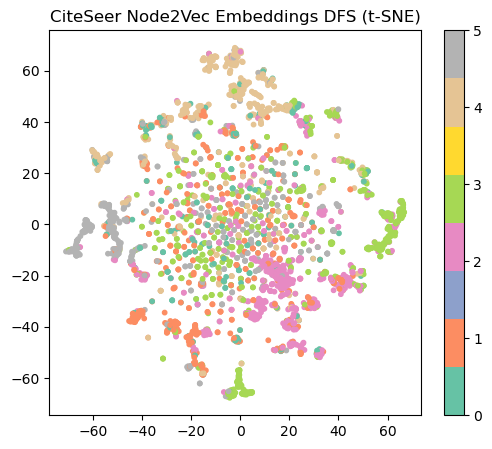

In [17]:
print("\033[1;31mPlots for the CiteSeer Embeddings\033[0m")
plot_embeddings(emb_citeseer_deepwalk, data_citeseer.y, "CiteSeer DeepWalk Embeddings (t-SNE)")
plot_embeddings(emb_citeseer_n2v_bfs, data_citeseer.y, "CiteSeer Node2Vec Embeddings BFS (t-SNE)")
plot_embeddings(emb_citeseer_n2v_dfs, data_citeseer.y, "CiteSeer Node2Vec Embeddings DFS (t-SNE)")

In [18]:
def evaluate_embeddings(emb, data):
    """
    Train logistic regression on the embeddings 
    using train_mask, validate on val_mask, test on test_mask.
    """
    X = emb.detach().cpu().numpy()
    Y = data.y.detach().cpu().numpy()

    train_mask = data.train_mask.cpu().numpy()
    val_mask   = data.val_mask.cpu().numpy()
    test_mask  = data.test_mask.cpu().numpy()

    X_train, Y_train = X[train_mask], Y[train_mask]
    X_val,   Y_val   = X[val_mask],   Y[val_mask]
    X_test,  Y_test  = X[test_mask],  Y[test_mask]

    # Simple Logistic Regression
    clf = LogisticRegression(max_iter=2000)
    clf.fit(X_train, Y_train)

    val_pred  = clf.predict(X_val)
    test_pred = clf.predict(X_test)

    val_acc  = accuracy_score(Y_val, val_pred)
    test_acc = accuracy_score(Y_test, test_pred)
    return val_acc, test_acc

# Evaluate on Cora
val_acc_cora_dw, test_acc_cora_dw = evaluate_embeddings(emb_cora_deepwalk, data_cora)
val_acc_cora_n2v_bfs, test_acc_cora_n2v_bfs = evaluate_embeddings(emb_cora_n2v_bfs, data_cora)
val_acc_cora_n2v_dfs, test_acc_cora_n2v_dfs = evaluate_embeddings(emb_cora_n2v_dfs, data_cora)
print(f"\nCora classification accuracy (DeepWalk): val={val_acc_cora_dw:.4f}, test={test_acc_cora_dw:.4f}")
print(f"Cora classification accuracy BFS (Node2Vec): val={val_acc_cora_n2v_bfs:.4f}, test={test_acc_cora_n2v_bfs:.4f}")
print(f"Cora classification accuracy DFS (Node2Vec): val={val_acc_cora_n2v_dfs:.4f}, test={test_acc_cora_n2v_dfs:.4f}")

# Evaluate on CiteSeer
val_acc_cs_dw, test_acc_cs_dw = evaluate_embeddings(emb_citeseer_deepwalk, data_citeseer)
val_acc_cs_n2v_bfs, test_acc_cs_n2v_bfs = evaluate_embeddings(emb_citeseer_n2v_bfs, data_citeseer)
val_acc_cs_n2v_dfs, test_acc_cs_n2v_dfs = evaluate_embeddings(emb_citeseer_n2v_dfs, data_citeseer)
print(f"\nCiteSeer classification accuracy (DeepWalk): val={val_acc_cs_dw:.4f}, test={test_acc_cs_dw:.4f}")
print(f"CiteSeer classification accuracy BFS (Node2Vec): val={val_acc_cs_n2v_bfs:.4f}, test={test_acc_cs_n2v_bfs:.4f}")
print(f"CiteSeer classification accuracy DFS (Node2Vec): val={val_acc_cs_n2v_dfs:.4f}, test={test_acc_cs_n2v_dfs:.4f}")


Cora classification accuracy (DeepWalk): val=0.7040, test=0.7170
Cora classification accuracy BFS (Node2Vec): val=0.6100, test=0.6310
Cora classification accuracy DFS (Node2Vec): val=0.6940, test=0.7310

CiteSeer classification accuracy (DeepWalk): val=0.4760, test=0.4830
CiteSeer classification accuracy BFS (Node2Vec): val=0.4040, test=0.3900
CiteSeer classification accuracy DFS (Node2Vec): val=0.5040, test=0.4840
